# Naive CAPM Calculations #

### CAPM Model using Simple Linear Regression Model ###

In [64]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Get Data
from fredapi import Fred
import logging

# Pretty Notation
from IPython.display import display, Math

In [65]:
# Data Collection Function from FRED
def get_fred_data(symbol: str) -> pd.DataFrame:
    
    fred_key = '0174cb93931388a2bf305663e4117fd3'

    fred = Fred(api_key = fred_key)
    
    df = fred.get_series(symbol)
    
    return df

In [66]:
# Nvidia Data
df_nvda = pd.read_csv(rf"..\stocks\NVDA.csv")
df_nvda = df_nvda.set_index('Date')
df_nvda.index = pd.to_datetime(df_nvda.index)

df_nvda = df_nvda.loc['2015-01-01':]

df_nvda

,Instrument,Open Price,High Price,Low Price,Close Price,Adjusted_close,Volume,Company Market Cap,Average Number of Shares Outstanding,Book Value per Share,...,Shares used to calculate Basic EPS - Total,T12M_Revenue,T12M_Net_Income,Announce_Date,Market_cap_calculado,Price_to_Sales,Price_to_Book,Price_to_Book_inverse,EPS_calculado,Price_to_Earnings
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NVDA.OQ,0.50325,0.50700,0.49550,0.503250,0.503250,57474359.0,1.083813e+10,2.284000e+10,0.198591,...,2.232000e+10,4.403972e+09,5.301670e+08,2014-11-06,1.090875e+10,2.477026,2.534098,0.394618,0.023753,21.186796
2015-01-05,NVDA.OQ,0.50325,0.50425,0.49250,0.494750,0.494750,58736639.0,1.070224e+10,2.284000e+10,0.198591,...,2.232000e+10,4.403972e+09,5.301670e+08,2014-11-06,1.072450e+10,2.435188,2.491297,0.401397,0.023753,20.828946
2015-01-06,NVDA.OQ,0.49550,0.49600,0.47925,0.479750,0.479750,74572639.0,1.068322e+10,2.284000e+10,0.198591,...,2.232000e+10,4.403972e+09,5.301670e+08,2014-11-06,1.039935e+10,2.361357,2.415765,0.413948,0.023753,20.197447
2015-01-07,NVDA.OQ,0.48325,0.48725,0.47700,0.478375,0.478375,47304679.0,1.072942e+10,2.284000e+10,0.198591,...,2.232000e+10,4.403972e+09,5.301670e+08,2014-11-06,1.036955e+10,2.354589,2.408841,0.415137,0.023753,20.139560
2015-01-08,NVDA.OQ,0.48400,0.49950,0.48375,0.496500,0.496500,51790239.0,1.065332e+10,2.284000e+10,0.198591,...,2.232000e+10,4.403972e+09,5.301670e+08,2014-11-06,1.076243e+10,2.443802,2.500109,0.399983,0.023753,20.902621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,NVDA.OQ,142.97000,144.41000,141.78000,143.590000,143.590000,NaN,NaN,2.489000e+10,1.998455,...,2.462000e+10,7.977400e+10,4.259700e+10,2024-08-28,3.530878e+12,44.261014,71.850517,0.013918,1.730179,82.991427
2024-10-23,NVDA.OQ,142.00000,142.43000,137.46000,139.560000,139.560000,NaN,NaN,2.489000e+10,1.998455,...,2.462000e+10,7.977400e+10,4.259700e+10,2024-08-28,3.431780e+12,43.018783,69.833959,0.014320,1.730179,80.662187
2024-10-24,NVDA.OQ,140.82000,141.35000,138.47000,140.410000,140.410000,NaN,NaN,2.489000e+10,1.998455,...,2.462000e+10,7.977400e+10,4.259700e+10,2024-08-28,3.452682e+12,43.280792,70.259287,0.014233,1.730179,81.153466


In [67]:
# We will use the 10 years bond rate as the RFR

rf = get_fred_data('DGS10')
rf.index = pd.to_datetime(rf.index)
rf = rf.loc['2015-01-01':]

rf

2015-01-01     NaN
2015-01-02    2.12
2015-01-05    2.04
2015-01-06    1.97
2015-01-07    1.96
              ... 
2025-03-31    4.23
2025-04-01    4.17
2025-04-02    4.20
2025-04-03    4.06
2025-04-04    4.01
Length: 2677, dtype: float64

In [68]:
# Nvidia Data
sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

sp500

,sp_500
Date,
2015-01-05,2020.579956
2015-01-06,2002.609985
2015-01-07,2025.900024
2015-01-08,2062.139893
2015-01-09,2044.810059
...,...
2024-12-24,6040.040039
2024-12-26,6037.589844
2024-12-27,5970.839844


In [69]:
# Create the DataFrame

data = pd.DataFrame()

data['stock_price'] = df_nvda['Adjusted_close']
data['annual_rfr'] = rf
data['benchmark'] = sp500

data = data.dropna()

data

,stock_price,annual_rfr,benchmark
Date,,,
2015-01-05,0.494750,2.04,2020.579956
2015-01-06,0.479750,1.97,2002.609985
2015-01-07,0.478375,1.96,2025.900024
2015-01-08,0.496500,2.03,2062.139893
2015-01-09,0.498500,1.98,2044.810059
...,...,...,...
2024-10-22,143.590000,4.20,5851.200195
2024-10-23,139.560000,4.24,5797.419922
2024-10-24,140.410000,4.21,5809.859863


In [70]:
# Now the returns

data['stock_returns'] = data['stock_price'].pct_change(1).mul(100)
data['daily_rfr'] = (((1 + (data['annual_rfr'].div(100)))**(1/360)) - 1).mul(100)
data['market_returns'] = data['benchmark'].pct_change(1).mul(100)

data

,stock_price,annual_rfr,benchmark,stock_returns,daily_rfr,market_returns
Date,,,,,,
2015-01-05,0.494750,2.04,2020.579956,NaN,0.005610,NaN
2015-01-06,0.479750,1.97,2002.609985,-3.031834,0.005419,-0.889347
2015-01-07,0.478375,1.96,2025.900024,-0.286608,0.005392,1.162984
2015-01-08,0.496500,2.03,2062.139893,3.788869,0.005583,1.788828
2015-01-09,0.498500,1.98,2044.810059,0.402820,0.005446,-0.840381
...,...,...,...,...,...,...
2024-10-22,143.590000,4.20,5851.200195,-0.083501,0.011429,-0.047485
2024-10-23,139.560000,4.24,5797.419922,-2.806602,0.011536,-0.919132
2024-10-24,140.410000,4.21,5809.859863,0.609057,0.011456,0.214577


In [71]:
# We use the excess returns

data['stock_excess'] = data['stock_returns'] - data['daily_rfr']
data['market_excess'] = data['market_returns'] - data['daily_rfr']

data

,stock_price,annual_rfr,benchmark,stock_returns,daily_rfr,market_returns,stock_excess,market_excess
Date,,,,,,,,
2015-01-05,0.494750,2.04,2020.579956,NaN,0.005610,NaN,NaN,NaN
2015-01-06,0.479750,1.97,2002.609985,-3.031834,0.005419,-0.889347,-3.037253,-0.894766
2015-01-07,0.478375,1.96,2025.900024,-0.286608,0.005392,1.162984,-0.292000,1.157592
2015-01-08,0.496500,2.03,2062.139893,3.788869,0.005583,1.788828,3.783286,1.783245
2015-01-09,0.498500,1.98,2044.810059,0.402820,0.005446,-0.840381,0.397373,-0.845828
...,...,...,...,...,...,...,...,...
2024-10-22,143.590000,4.20,5851.200195,-0.083501,0.011429,-0.047485,-0.094930,-0.058914
2024-10-23,139.560000,4.24,5797.419922,-2.806602,0.011536,-0.919132,-2.818138,-0.930668
2024-10-24,140.410000,4.21,5809.859863,0.609057,0.011456,0.214577,0.597601,0.203122


In [72]:
# We know how to calculate a beta, but not a rolling beta

data['rolling_cov'] = data['stock_excess'].rolling(window=252).cov(data['market_excess'])
data['rolling_var_market'] = data['market_excess'].rolling(window=252).var()

# Rolling beta
data['rolling_beta'] = data['rolling_cov'] / data['rolling_var_market']

data.dropna()

,stock_price,annual_rfr,benchmark,stock_returns,daily_rfr,market_returns,stock_excess,market_excess,rolling_cov,rolling_var_market,rolling_beta
Date,,,,,,,,,,,
2016-01-07,0.75700,2.16,1943.089966,-3.964478,0.005936,-2.370044,-3.970415,-2.375981,1.181917,0.980737,1.205131
2016-01-08,0.74075,2.13,1922.030029,-2.146631,0.005855,-1.083837,-2.152486,-1.089692,1.180640,0.982252,1.201972
2016-01-11,0.74200,2.17,1923.670044,0.168748,0.005963,0.085327,0.162784,0.079364,1.182895,0.976772,1.211025
2016-01-12,0.75450,2.12,1938.680054,1.684636,0.005828,0.780280,1.678809,0.774452,1.161754,0.966303,1.202267
2016-01-13,0.73150,2.08,1890.280029,-3.048376,0.005719,-2.496545,-3.054095,-2.502264,1.194311,0.988017,1.208795
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,143.59000,4.20,5851.200195,-0.083501,0.011429,-0.047485,-0.094930,-0.058914,1.624489,0.603352,2.692440
2024-10-23,139.56000,4.24,5797.419922,-2.806602,0.011536,-0.919132,-2.818138,-0.930668,1.626076,0.600041,2.709942
2024-10-24,140.41000,4.21,5809.859863,0.609057,0.011456,0.214577,0.597601,0.203122,1.630051,0.599712,2.718058


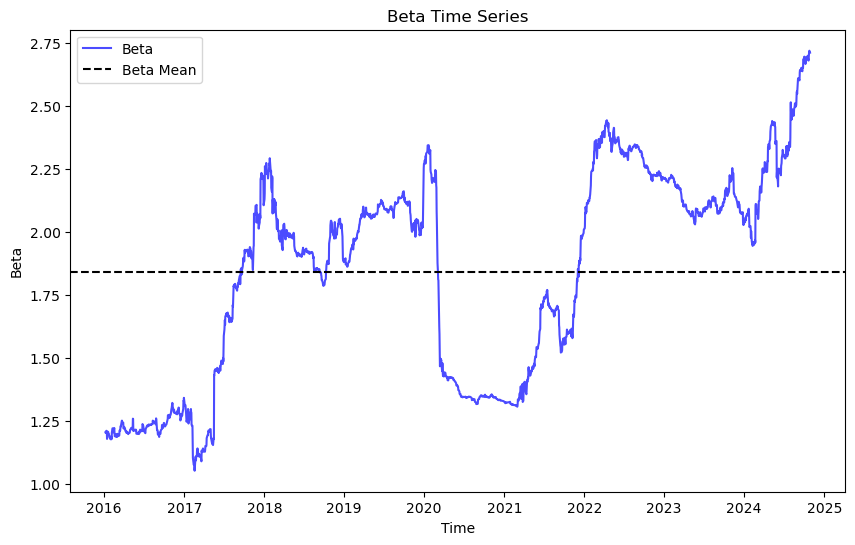

In [73]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(data['rolling_beta'], label='Beta', color='blue', alpha=0.7)
plt.axhline(y=data['rolling_beta'].mean(), color='black', linestyle='dashed', label='Beta Mean')

# Config
plt.title('Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()

# Show
plt.show()

In [74]:
# Now we are interested in obtaining the alpha

data['rolling_avg_stock'] = data['stock_excess'].rolling(window=252).mean()
data['rolling_avg_market'] = data['market_excess'].rolling(window=252).mean()

data['rolling_alpha'] = data['rolling_avg_stock'] - data['rolling_beta'] * data['rolling_avg_market']

data.dropna()

,stock_price,annual_rfr,benchmark,stock_returns,daily_rfr,market_returns,stock_excess,market_excess,rolling_cov,rolling_var_market,rolling_beta,rolling_avg_stock,rolling_avg_market,rolling_alpha
Date,,,,,,,,,,,,,,
2016-01-07,0.75700,2.16,1943.089966,-3.964478,0.005936,-2.370044,-3.970415,-2.375981,1.181917,0.980737,1.205131,0.186798,-0.016509,0.206694
2016-01-08,0.74075,2.13,1922.030029,-2.146631,0.005855,-1.083837,-2.152486,-1.089692,1.180640,0.982252,1.201972,0.190309,-0.017283,0.211083
2016-01-11,0.74200,2.17,1923.670044,0.168748,0.005963,0.085327,0.162784,0.079364,1.182895,0.976772,1.211025,0.192114,-0.021561,0.218225
2016-01-12,0.75450,2.12,1938.680054,1.684636,0.005828,0.780280,1.678809,0.774452,1.161754,0.966303,1.202267,0.183763,-0.025565,0.214498
2016-01-13,0.73150,2.08,1890.280029,-3.048376,0.005719,-2.496545,-3.054095,-2.502264,1.194311,0.988017,1.208795,0.170067,-0.032138,0.208915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,143.59000,4.20,5851.200195,-0.083501,0.011429,-0.047485,-0.094930,-0.058914,1.624489,0.603352,2.692440,0.528836,0.115898,0.216787
2024-10-23,139.56000,4.24,5797.419922,-2.806602,0.011536,-0.919132,-2.818138,-0.930668,1.626076,0.600041,2.709942,0.524436,0.117252,0.206689
2024-10-24,140.41000,4.21,5809.859863,0.609057,0.011456,0.214577,0.597601,0.203122,1.630051,0.599712,2.718058,0.511633,0.118779,0.188784


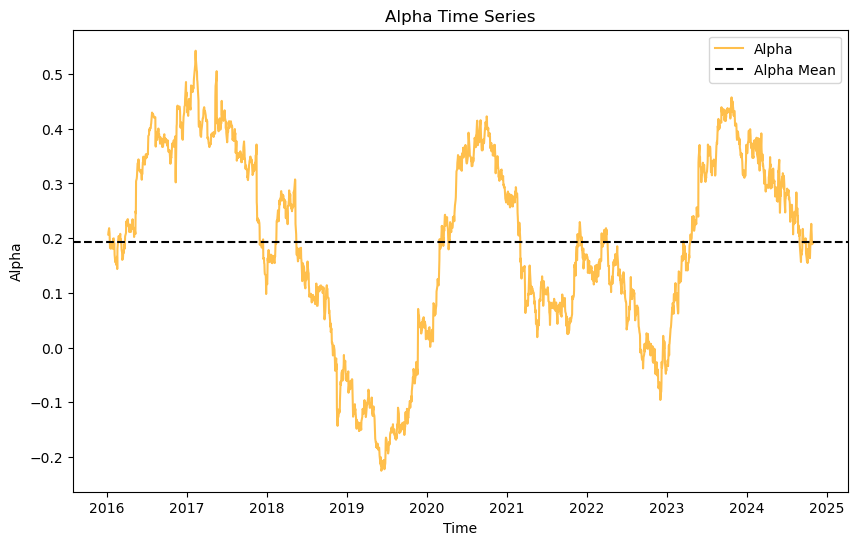

In [75]:
# Create Plot

# Crear el gráfico de la serie de tiempo y las medias móviles exponenciales
plt.figure(figsize=(10, 6))
plt.plot(data['rolling_alpha'], label='Alpha', color='orange', alpha=0.7)
plt.axhline(y=data['rolling_alpha'].mean(), color='black', linestyle='dashed', label='Alpha Mean')

# Añadir título y etiquetas
plt.title('Alpha Time Series')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()

# Mostrar el gráfico
plt.show()

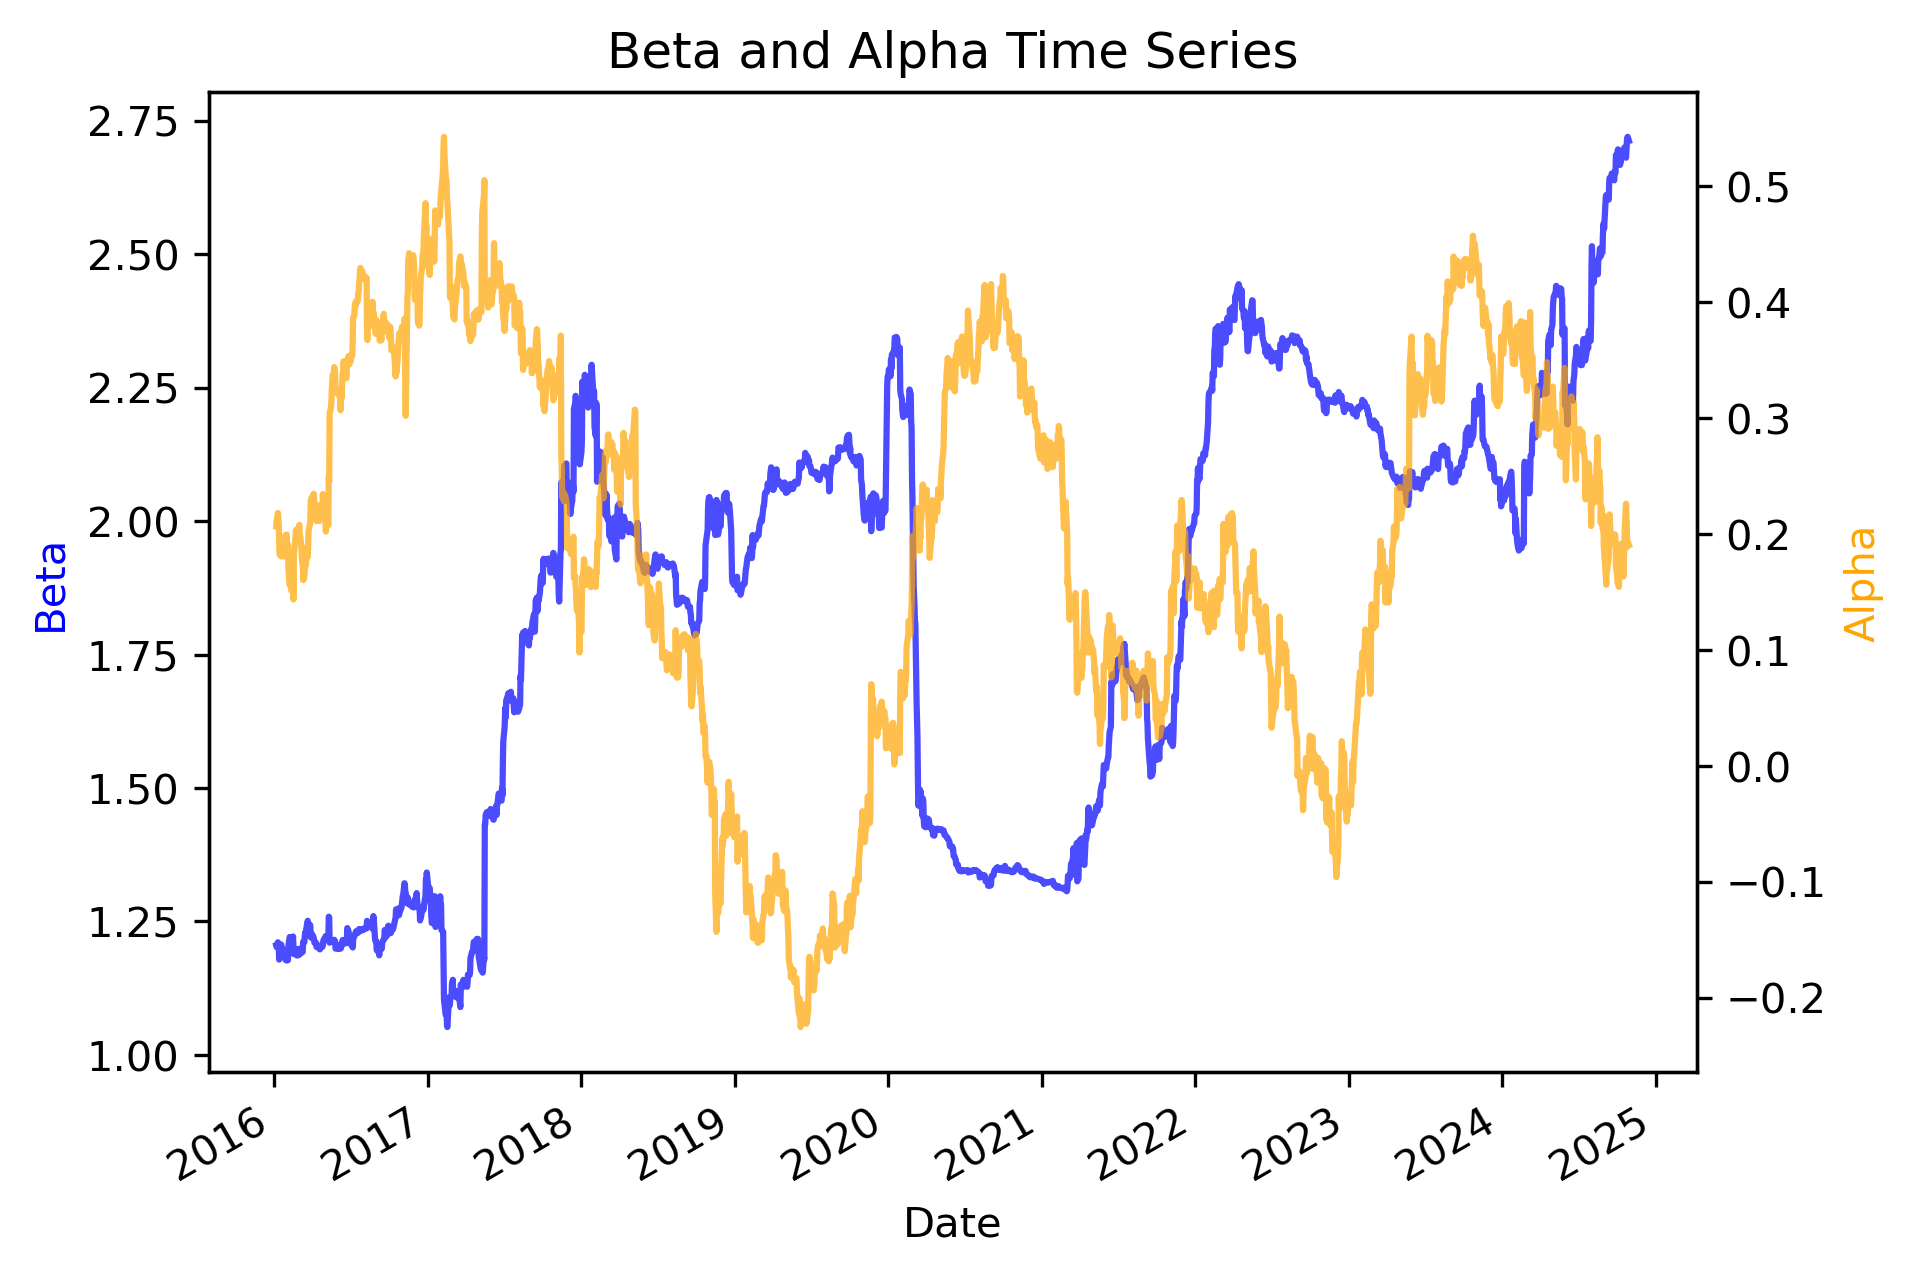

In [76]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Unemployment Rate Plot
data['rolling_beta'].plot(color = 'blue', ax = ax1, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Beta', 
    color='blue'
    )

# Unemployment Mentions Plot
ax2 = ax1.twinx()

data['rolling_alpha'].plot(color = 'orange', ax = ax2, alpha=0.7)
ax2.set_ylabel(
    'Alpha', 
    color='orange'
    )

plt.title('Beta and Alpha Time Series')
plt.show()

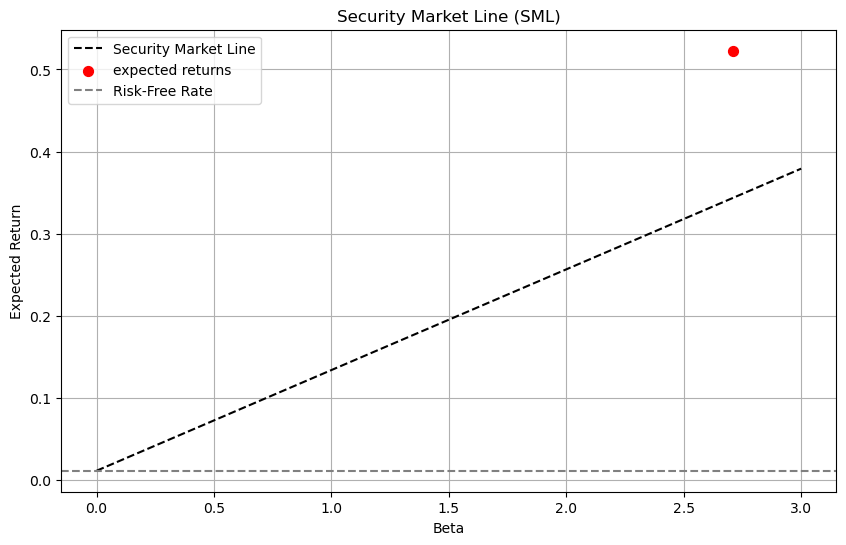

In [77]:
# Security Market Line

# Parámeters
risk_free_rate = data['daily_rfr'].iloc[-1]
market_risk_premium = data['rolling_avg_market'].iloc[-1]

# Random Betas
betas = np.linspace(0, 3, 100)  # Rango de betas de 0 a 2

# Expected Returns
expected_returns = risk_free_rate + market_risk_premium * betas

# Plot
plt.figure(figsize=(10, 6))

plt.plot(betas, expected_returns, color='black', linestyle='--', label='Security Market Line')
plt.scatter(data['rolling_beta'].iloc[-1], data['rolling_avg_stock'].iloc[-1], color='red', s=50, label='expected returns')  

# Config
plt.title('Security Market Line (SML)')
plt.xlabel('Beta')
plt.ylabel('Expected Return')

# RFR Line
plt.axhline(y=risk_free_rate, color='grey', linestyle='--', label='Risk-Free Rate')

# Legends
plt.legend()

plt.grid(True)
plt.show()

In [78]:
# Now we have to calculate the Treynor's Ratio

data['treynors_ratio'] = data['stock_excess'].div(data['rolling_beta'])

data.dropna()

,stock_price,annual_rfr,benchmark,stock_returns,daily_rfr,market_returns,stock_excess,market_excess,rolling_cov,rolling_var_market,rolling_beta,rolling_avg_stock,rolling_avg_market,rolling_alpha,treynors_ratio
Date,,,,,,,,,,,,,,,
2016-01-07,0.75700,2.16,1943.089966,-3.964478,0.005936,-2.370044,-3.970415,-2.375981,1.181917,0.980737,1.205131,0.186798,-0.016509,0.206694,-3.294593
2016-01-08,0.74075,2.13,1922.030029,-2.146631,0.005855,-1.083837,-2.152486,-1.089692,1.180640,0.982252,1.201972,0.190309,-0.017283,0.211083,-1.790795
2016-01-11,0.74200,2.17,1923.670044,0.168748,0.005963,0.085327,0.162784,0.079364,1.182895,0.976772,1.211025,0.192114,-0.021561,0.218225,0.134419
2016-01-12,0.75450,2.12,1938.680054,1.684636,0.005828,0.780280,1.678809,0.774452,1.161754,0.966303,1.202267,0.183763,-0.025565,0.214498,1.396369
2016-01-13,0.73150,2.08,1890.280029,-3.048376,0.005719,-2.496545,-3.054095,-2.502264,1.194311,0.988017,1.208795,0.170067,-0.032138,0.208915,-2.526561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,143.59000,4.20,5851.200195,-0.083501,0.011429,-0.047485,-0.094930,-0.058914,1.624489,0.603352,2.692440,0.528836,0.115898,0.216787,-0.035258
2024-10-23,139.56000,4.24,5797.419922,-2.806602,0.011536,-0.919132,-2.818138,-0.930668,1.626076,0.600041,2.709942,0.524436,0.117252,0.206689,-1.039925
2024-10-24,140.41000,4.21,5809.859863,0.609057,0.011456,0.214577,0.597601,0.203122,1.630051,0.599712,2.718058,0.511633,0.118779,0.188784,0.219863


In [79]:
# And the Sharpe Ratio

data['rolling_std_stock'] = data['stock_returns'].rolling(window=252).std()
data['sharpe_ratio'] = data['stock_excess'].div(data['rolling_std_stock'])

data.dropna()

,stock_price,annual_rfr,benchmark,stock_returns,daily_rfr,market_returns,stock_excess,market_excess,rolling_cov,rolling_var_market,rolling_beta,rolling_avg_stock,rolling_avg_market,rolling_alpha,treynors_ratio,rolling_std_stock,sharpe_ratio
Date,,,,,,,,,,,,,,,,,
2016-01-07,0.75700,2.16,1943.089966,-3.964478,0.005936,-2.370044,-3.970415,-2.375981,1.181917,0.980737,1.205131,0.186798,-0.016509,0.206694,-3.294593,2.208840,-1.797511
2016-01-08,0.74075,2.13,1922.030029,-2.146631,0.005855,-1.083837,-2.152486,-1.089692,1.180640,0.982252,1.201972,0.190309,-0.017283,0.211083,-1.790795,2.204391,-0.976454
2016-01-11,0.74200,2.17,1923.670044,0.168748,0.005963,0.085327,0.162784,0.079364,1.182895,0.976772,1.211025,0.192114,-0.021561,0.218225,0.134419,2.204180,0.073853
2016-01-12,0.75450,2.12,1938.680054,1.684636,0.005828,0.780280,1.678809,0.774452,1.161754,0.966303,1.202267,0.183763,-0.025565,0.214498,1.396369,2.194487,0.765012
2016-01-13,0.73150,2.08,1890.280029,-3.048376,0.005719,-2.496545,-3.054095,-2.502264,1.194311,0.988017,1.208795,0.170067,-0.032138,0.208915,-2.526561,2.203900,-1.385768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,143.59000,4.20,5851.200195,-0.083501,0.011429,-0.047485,-0.094930,-0.058914,1.624489,0.603352,2.692440,0.528836,0.115898,0.216787,-0.035258,3.255501,-0.029160
2024-10-23,139.56000,4.24,5797.419922,-2.806602,0.011536,-0.919132,-2.818138,-0.930668,1.626076,0.600041,2.709942,0.524436,0.117252,0.206689,-1.039925,3.259290,-0.864648
2024-10-24,140.41000,4.21,5809.859863,0.609057,0.011456,0.214577,0.597601,0.203122,1.630051,0.599712,2.718058,0.511633,0.118779,0.188784,0.219863,3.252602,0.183730


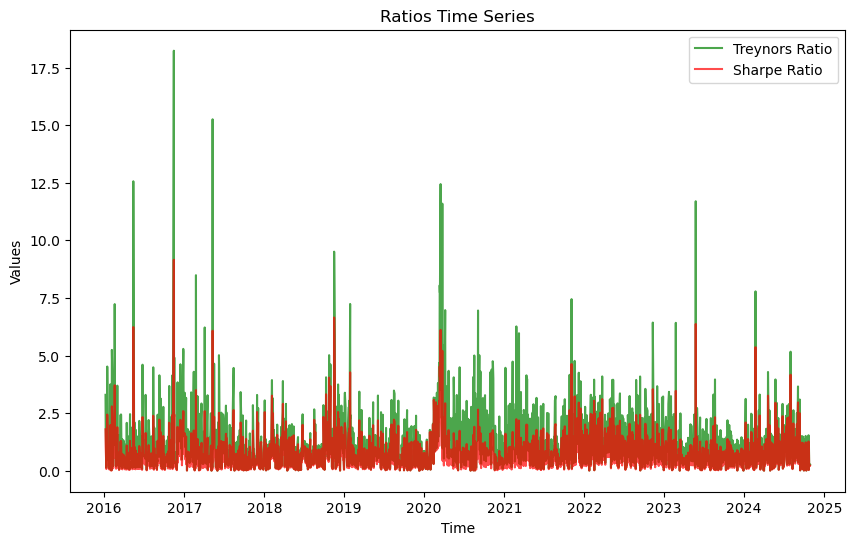

In [80]:
# Create Plot to demonstrate the Sharpe Ratio is always smaller than the Treynors Ratio

plt.figure(figsize=(10, 6))
plt.plot(abs(data['treynors_ratio']), label='Treynors Ratio', color='green', alpha=0.7)
plt.plot(abs(data['sharpe_ratio']), label='Sharpe Ratio', color='red', alpha=0.7)

# Config
plt.title('Ratios Time Series')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Show
plt.show()

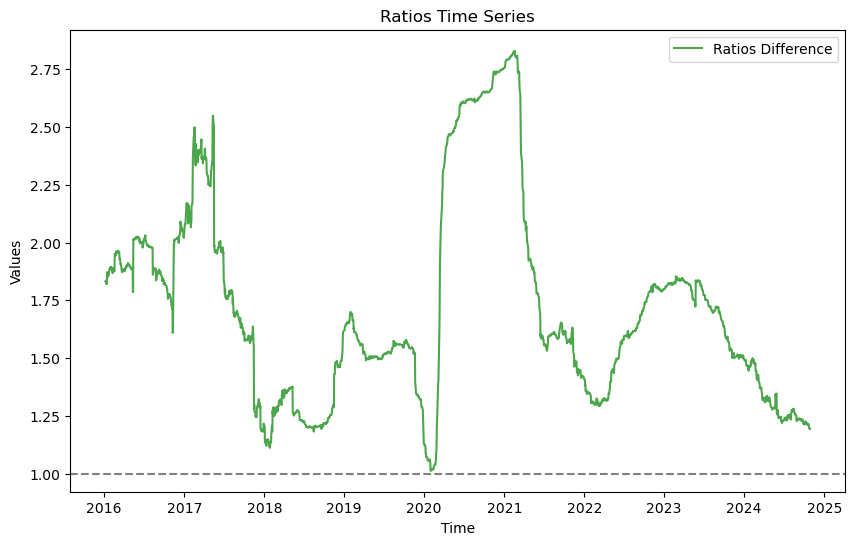

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(abs(data['treynors_ratio'] / abs(data['sharpe_ratio'])), label='Ratios Difference', color='green', alpha=0.7)
plt.axhline(y=1, color='grey', linestyle='--')

# Config
plt.title('Ratios Time Series')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Show
plt.show()

In [82]:
data['rolling_beta'].dropna()

Date
2016-01-07    1.205131
2016-01-08    1.201972
2016-01-11    1.211025
2016-01-12    1.202267
2016-01-13    1.208795
                ...   
2024-10-22    2.692440
2024-10-23    2.709942
2024-10-24    2.718058
2024-10-25    2.719456
2024-10-28    2.711801
Name: rolling_beta, Length: 2202, dtype: float64